In [211]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize, dual_annealing, differential_evolution
from deap import base, creator, tools, algorithms

# Constants for the rocket
g0 = 9.81  # gravitational acceleration in m/s²

# Specific impulse for each stage (seconds)
Isp = np.array([282, 348])  # Falcon 9 is a two-stage rocket

# Input Parameters for the analysis
vf = 2000  

# Stage weight fractions
beta = np.array([0.75, 0.15])  # approximate values for Falcon 9

# Structural mass fractions
epsilon = np.array([0.06, 0.04])  # approximate values for Falcon 9

# Stage efficiency factors
alpha = np.array([1, 1])  # typical values close to 1

# List of solvers to try
solvers = ['newton', 'bisection', 'secant', 'scipy', 'genetic',
           'fixed_point', 'false_position', 'nelder_mead', 'powell', 'annealing', 'pso']

# Make sure the DEAP creator components are defined only once
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

def find_valid_bracket(f):
    a, b = 0, 1
    for _ in range(100):
        if f(a) * f(b) < 0:
            return a, b
        a /= 1.1
        b *= 1.1
    raise ValueError("Could not find a valid bracket.")

def Nstage(vf, beta, epsilon, alpha, solver='newton', tol=1e-9, max_iter=100):
    def f(p):
        p = np.clip(p, 1e-6, 1)
        return np.sum(beta * np.log(np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9))) - vf

    def df(p):
        p = np.clip(p, 1e-6, 1)
        return np.sum(beta * (alpha * (1 - epsilon)) / np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9))

    if solver == 'newton':
        p = 0.5
        for _ in range(max_iter):
            f_val, df_val = f(p), df(p)
            if abs(f_val) < tol:
                return p
            if abs(df_val) < 1e-12:
                return None
            p -= f_val / df_val
        return None
    
    elif solver == 'bisection':
        try:
            a, b = find_valid_bracket(f)
        except ValueError:
            return None
        for _ in range(max_iter):
            p = (a + b) / 2.0
            if abs(f(p)) < tol:
                return p
            if f(a) * f(p) < 0:
                b = p
            else:
                a = p
        return None
    
    elif solver == 'secant':
        p0, p1 = 0.1, 0.9
        for _ in range(max_iter):
            f0, f1 = f(p0), f(p1)
            if abs(f1) < tol:
                return p1
            if abs(f1 - f0) < 1e-12:
                return None
            p_new = p1 - f1 * (p1 - p0) / (f1 - f0)
            p0, p1 = p1, p_new
        return None
    
    elif solver == 'scipy':
        try:
            a, b = find_valid_bracket(f)
            sol = root_scalar(f, bracket=[a, b], method='brentq', xtol=tol)
            return sol.root if sol.converged else None
        except ValueError:
            return None
    
    elif solver == 'genetic':
        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.uniform, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", lambda ind: (abs(f(ind[0])),))
        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=3)
    
        pop = toolbox.population(n=100)
        algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
        return tools.selBest(pop, k=1)[0][0]
    
    elif solver == 'annealing':
        res = dual_annealing(lambda p: abs(f(p[0])), bounds=[(0, 1)])
        return res.x[0]
    
    elif solver == 'pso':
        res = differential_evolution(lambda p: abs(f(p[0])), bounds=[(0, 1)])
        return res.x[0]
    
    else:
        return None


Running solver: SLSQP
SLSQP -> Time: 0.0010s | Final Error: 3.75e+06 | Physical Mismatch: -1935.88 | Solution: [0.1 0.1]

Running solver: Trust-Constr
Trust-Constr -> Time: 0.1947s | Final Error: 2.21e-08 | Physical Mismatch: 0.00 | Solution: [0.05298083 0.05038809]

Running solver: Differential Evolution


c:\Users\User\Documents\GitHub\rocket_propulsion\venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Differential Evolution -> Time: 0.3276s | Final Error: 0.00e+00 | Physical Mismatch: 0.00 | Solution: [0.05143599 0.05207532]

Running solver: Genetic Algorithm
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  6.871021E+07 |  5.438769E+05
Callback at generation 1
     2 |      400 |  3.024278E+07 |  1.353796E+05
Callback at generation 2
     3 |      600 |  1.339910E+07 |  1.170506E+05
Callback at generation 3
     4 |      800 |  5.535732E+06 |  1.170506E+05
Callback at generation 4
     5 |     1000 |  1.792990E+06 |  1.217907E+02
Callback at generation 5
     6 |     1200 |  4.305876E+05 |  3.9661690082
Callback at generation 6
     7 |     1400 |  1.368476E+05 |  3.9661690082
Callback at generation 7
     8 |     1600 |  4.272996E+04 |  0.0352387875
Callback at generation 8
     9 |     1800 |  6.017860E+03 |  0.0352387875
Callback at generation 9
    10 |     2000 |  1.172020E+03 |  0.0352387875
Callback at generation 10
    11 |     2200 |  3.293602E+02 |  0

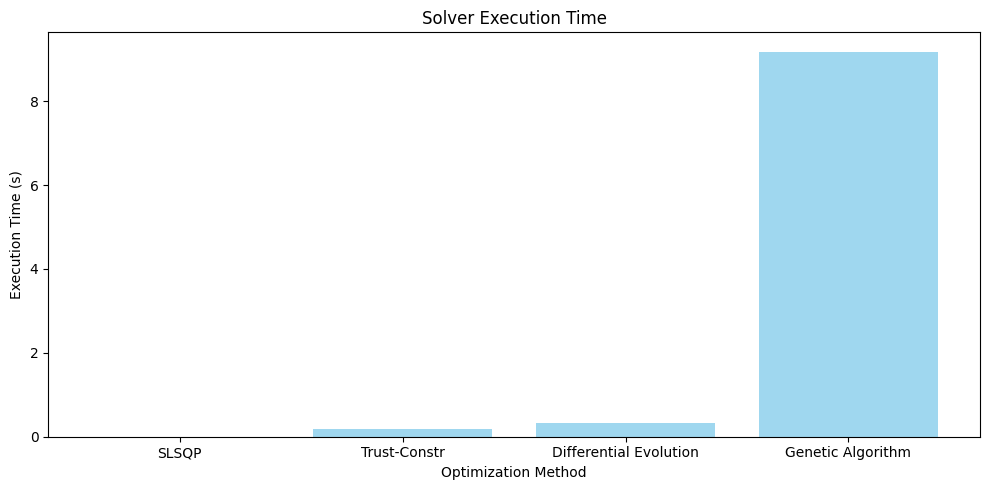

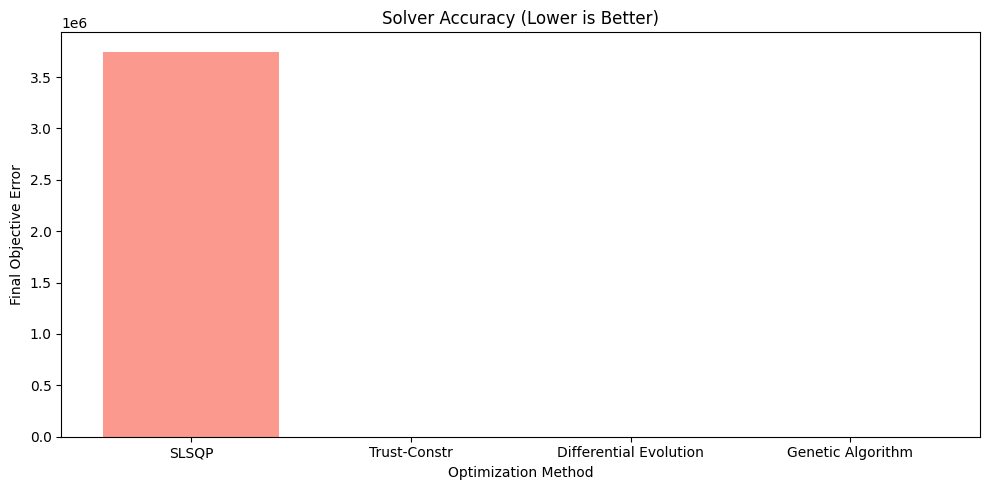

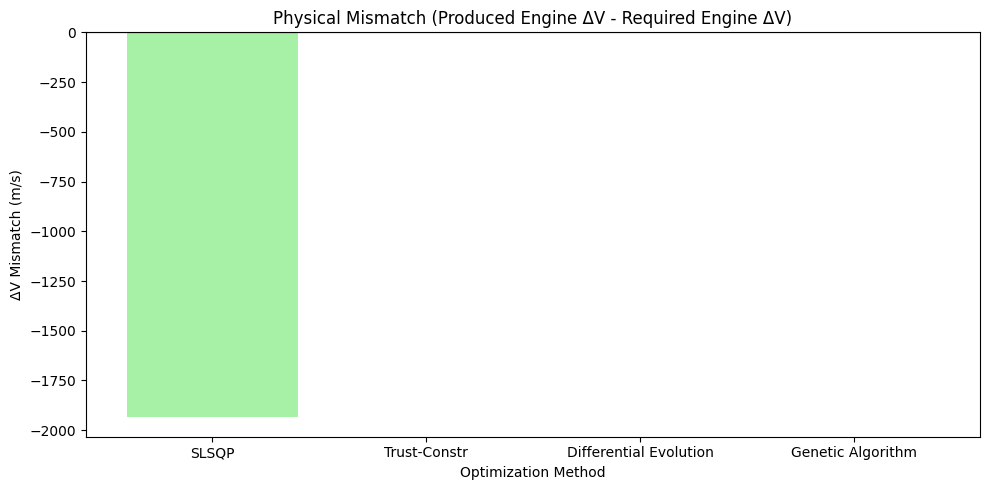

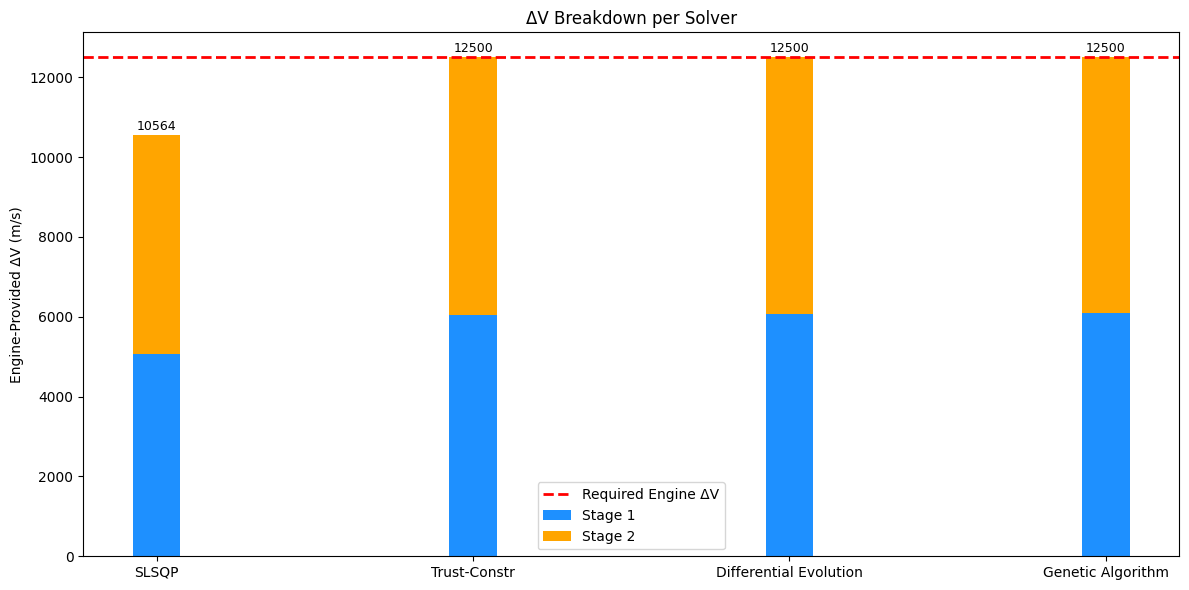

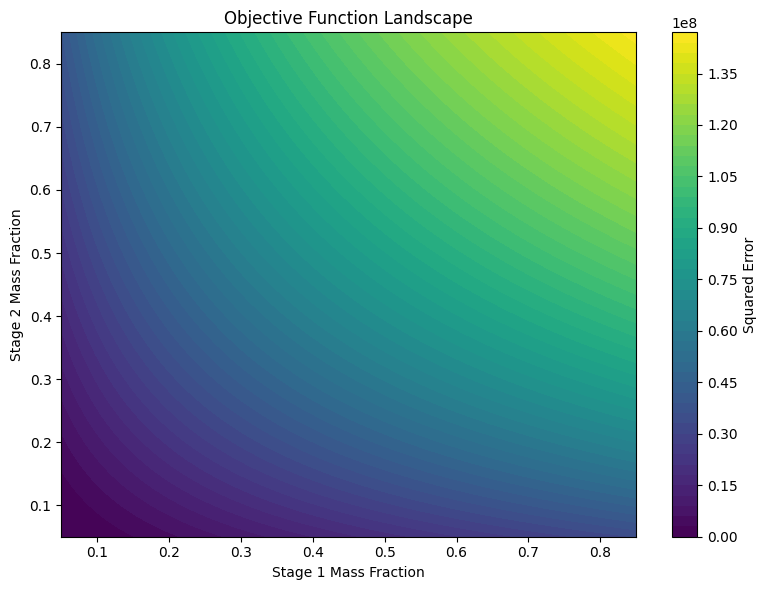

GA result does not have a valid history attribute. Ensure that 'callback' is working properly in solver_genetic_algorithm.
LaTeX summary written to results_summary.tex


In [212]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.core.problem import Problem
#from skopt import gp_minimize  # (Not used in this example)

# === Constants & Parameters ===
G0 = 9.81  # gravitational acceleration (m/s²)
ISP = np.array([282, 348])  # specific impulse for stage 1 and stage 2 (s)
EPSILON = np.array([0.03, 0.07])  # structural mass fractions for each stage
PAYLOAD_FRACTION = 0.03        # payload fraction (3% of total mass)
TOTAL_DELTA_V = 10500          # required net mission ΔV (m/s)

# Delta-V losses (m/s)
GRAVITY_LOSS = 1500
DRAG_LOSS = 500

# === Functions for ΔV Calculation and Objective ===

def delta_v_function(stage_fractions, isp):
    """
    Compute the engine-provided delta-V for each stage.
    
    Parameters:
        stage_fractions : array-like
            The design variables (mass fractions) for each stage.
        isp : array-like
            Specific impulse for each stage.
            
    Returns:
        Array of ΔV contributions for each stage.
    """
    # Note: A lower stage fraction means more propellant and thus a higher ΔV.
    return G0 * isp * np.log(1 / (EPSILON + PAYLOAD_FRACTION + stage_fractions))


def objective(stage_fractions, total_delta_v, isp):
    """
    Compute the squared error between the produced engine ΔV (sum of stages) 
    and the required engine ΔV (target ΔV plus losses).
    
    Parameters:
        stage_fractions : array-like
            The design variables (mass fractions) for each stage.
        total_delta_v : float
            The mission target ΔV (m/s) without engine losses.
        isp : array-like
            Specific impulse for each stage.
            
    Returns:
        Squared error.
    """
    required_engine_delta_v = total_delta_v + GRAVITY_LOSS + DRAG_LOSS
    produced_delta_v = np.sum(delta_v_function(stage_fractions, isp))
    return (produced_delta_v - required_engine_delta_v)**2


# === Problem Setup and Bounds ===
NUM_STAGES = len(ISP)
# Adjust the lower bound from 0.15 to 0.05 so that the optimum is reachable.
BOUNDS = [(0.05, 0.85) for _ in range(NUM_STAGES)]
# Use an initial guess closer to the expected optimum (e.g., near 0.1)
X0 = np.array([0.1, 0.1])

# === Benchmarking Helper Function ===
def benchmark_solver(method_name, solver_func):
    """
    Run and time an optimization solver.
    
    Returns:
        Tuple containing the method name, execution time, final objective error,
        optimized stage fractions, and physical mismatch.
    """
    start_time = time.time()
    result = solver_func()
    elapsed_time = time.time() - start_time

    # Extract optimized values based on the result type:
    if hasattr(result, "x"):
        optimized_fractions = result.x
        final_error = result.fun
    elif hasattr(result, "X"):
        # Check if result.X is 1D or 2D:
        if result.X.ndim == 1:
            optimized_fractions = result.X
        else:
            optimized_fractions = result.X[0]  # take the first solution
        final_error = objective(optimized_fractions, TOTAL_DELTA_V, ISP)
    else:
        optimized_fractions = result
        final_error = objective(optimized_fractions, TOTAL_DELTA_V, ISP)

    produced = np.sum(delta_v_function(optimized_fractions, ISP))
    required_engine_dv = TOTAL_DELTA_V + GRAVITY_LOSS + DRAG_LOSS
    physical_mismatch = produced - required_engine_dv
    
    print(f"{method_name} -> Time: {elapsed_time:.4f}s | Final Error: {final_error:.2e} | " \
          f"Physical Mismatch: {physical_mismatch:.2f} | Solution: {optimized_fractions}")
    
    return method_name, elapsed_time, final_error, optimized_fractions, physical_mismatch

# === Solver Definitions ===

def solver_slsqp():
    return minimize(objective, X0, args=(TOTAL_DELTA_V, ISP), bounds=BOUNDS, method='SLSQP')

def solver_trust_constr():
    return minimize(objective, X0, args=(TOTAL_DELTA_V, ISP), bounds=BOUNDS, method='trust-constr')

def solver_differential_evolution():
    return differential_evolution(objective, BOUNDS, args=(TOTAL_DELTA_V, ISP))

# --- pymoo Problem Class for the GA Solver ---
class StageOptimizationProblem(Problem):
    def __init__(self):
        # Use the same bounds as defined above.
        xl = np.array([b[0] for b in BOUNDS])
        xu = np.array([b[1] for b in BOUNDS])
        super().__init__(n_var=NUM_STAGES, n_obj=1, n_constr=0, xl=xl, xu=xu)
    
    def _evaluate(self, x, out, *args, **kwargs):
        required_engine_delta_v = TOTAL_DELTA_V + GRAVITY_LOSS + DRAG_LOSS
        # x is a 2D array (n_samples x NUM_STAGES)
        produced = np.sum(delta_v_function(x, ISP), axis=1)
        f = (produced - required_engine_delta_v)**2
        out["F"] = f[:, np.newaxis]

def solver_genetic_algorithm():
    problem = StageOptimizationProblem()
    algorithm = GA(pop_size=200, eliminate_duplicates=True)
    
    history = []  # to store history manually
    
    def callback(alg):
        print(f"Callback at generation {alg.n_gen}")
        # Save a copy of the current objective values from the population
        F_values = np.copy(alg.pop.get("F"))
        history.append(F_values)
    
    # Run the GA with callback and save_history enabled.
    res = pymoo_minimize(problem, algorithm, termination=('n_gen', 200),
                           seed=1, verbose=True, save_history=True, callback=callback)
    
    # Check if history was recorded by the callback.
    if len(history) == 0:
        print("Warning: No history was recorded in the callback!")
    else:
        print(f"Callback recorded history for {len(history)} generations.")
    
    # Attach the history manually if not present.
    if not hasattr(res, "history") or res.history is None or len(res.history) == 0:
        res.history = history
    else:
        print("Result already contains history data.")
    
    print("GA full result (final population):", res.X)
    return res

# === Run and Benchmark All Solvers ===
SOLVERS = [
    ("SLSQP", solver_slsqp),
    ("Trust-Constr", solver_trust_constr),
    ("Differential Evolution", solver_differential_evolution),
    ("Genetic Algorithm", solver_genetic_algorithm),
]

results = []
for name, func in SOLVERS:
    print("\nRunning solver:", name)
    res = benchmark_solver(name, func)
    results.append(res)

# Unpack results for plotting and further analysis.
solver_names, times, errors, solutions, mismatches = zip(*results)

# === Visualization: Solver Performance Metrics ===

# Execution Time Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(solver_names, times, color='skyblue', alpha=0.8)
plt.xlabel("Optimization Method")
plt.ylabel("Execution Time (s)")
plt.title("Solver Execution Time")
plt.tight_layout()
plt.savefig("execution_time.png")
plt.show()

# Final Objective Error Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(solver_names, errors, color='salmon', alpha=0.8)
plt.xlabel("Optimization Method")
plt.ylabel("Final Objective Error")
plt.title("Solver Accuracy (Lower is Better)")
plt.tight_layout()
plt.savefig("objective_error.png")
plt.show()

# Physical Mismatch Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(solver_names, mismatches, color='lightgreen', alpha=0.8)
plt.xlabel("Optimization Method")
plt.ylabel("ΔV Mismatch (m/s)")
plt.title("Physical Mismatch (Produced Engine ΔV - Required Engine ΔV)")
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig("physical_mismatch.png")
plt.show()

# === Visualization: ΔV Breakdown for Each Solver ===
required_engine_dv = TOTAL_DELTA_V + GRAVITY_LOSS + DRAG_LOSS

plt.figure(figsize=(12, 6))
bar_width = 0.15
indices = np.arange(len(solver_names))

for i, (name, sol) in enumerate(zip(solver_names, solutions)):
    if sol is None:
        continue
    dv_per_stage = delta_v_function(sol, ISP)
    total_engine_dv = np.sum(dv_per_stage)
    plt.bar(i, dv_per_stage[0], bar_width, label='Stage 1' if i == 0 else "", color='dodgerblue')
    plt.bar(i, dv_per_stage[1], bar_width, bottom=dv_per_stage[0], label='Stage 2' if i == 0 else "", color='orange')
    plt.text(i, total_engine_dv + 50, f"{total_engine_dv:.0f}", ha='center', va='bottom', fontsize=9)

plt.axhline(required_engine_dv, color='red', linestyle='--', linewidth=2, label='Required Engine ΔV')
plt.xticks(indices, solver_names)
plt.ylabel("Engine-Provided ΔV (m/s)")
plt.title("ΔV Breakdown per Solver")
plt.legend()
plt.tight_layout()
plt.savefig("dv_breakdown.png")
plt.show()

# === Visualization: Objective Function Contour Plot ===
def plot_objective_contour():
    f1 = np.linspace(BOUNDS[0][0], BOUNDS[0][1], 100)
    f2 = np.linspace(BOUNDS[1][0], BOUNDS[1][1], 100)
    F1, F2 = np.meshgrid(f1, f2)
    
    Z = np.zeros_like(F1)
    for i in range(F1.shape[0]):
        for j in range(F1.shape[1]):
            x_val = np.array([F1[i, j], F2[i, j]])
            Z[i, j] = objective(x_val, TOTAL_DELTA_V, ISP)
    
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(F1, F2, Z, levels=50, cmap='viridis')
    plt.colorbar(contour, label='Squared Error')
    plt.xlabel("Stage 1 Mass Fraction")
    plt.ylabel("Stage 2 Mass Fraction")
    plt.title("Objective Function Landscape")
    plt.tight_layout()
    plt.savefig("objective_contour.png")
    plt.show()

plot_objective_contour()

# === GA-Specific Visualization: Convergence Curve and Population Distribution ===

# Extract the GA result from the overall results.
ga_result = None
for name, _, _, sol, _ in results:
    if name == "Genetic Algorithm":
        ga_result = sol
        break

if ga_result is not None and hasattr(ga_result, "history") and ga_result.history:
    # Convert each entry in history to a NumPy array.
    history_arrays = [np.asarray(gen) for gen in ga_result.history]
    
    # Print out the shape of each generation's data for debugging.
    print("GA History shapes:")
    for i, arr in enumerate(history_arrays):
        print(f"Generation {i}: shape {arr.shape}")
    
    # Compute the best (minimum) objective value per generation.
    generations = np.arange(len(history_arrays))
    best_F = [np.min(arr) for arr in history_arrays]
    
    # Plot the convergence curve.
    plt.figure(figsize=(8, 5))
    plt.plot(generations, best_F, marker='o', linestyle='-')
    plt.xlabel("Generation")
    plt.ylabel("Best Objective Value")
    plt.title("GA Convergence Curve")
    plt.tight_layout()
    plt.savefig("ga_convergence.png")
    plt.show()
    
    # Plot the histogram for the final generation's objective values.
    final_F = history_arrays[-1].flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(final_F, bins=20, color='orchid', edgecolor='black', alpha=0.75)
    plt.xlabel("Objective Value")
    plt.ylabel("Frequency")
    plt.title("Final Population Objective Value Distribution (GA)")
    plt.tight_layout()
    plt.savefig("ga_population_hist.png")
    plt.show()
else:
    print("GA result does not have a valid history attribute. Ensure that 'callback' is working properly in solver_genetic_algorithm.")

# =============================================================================
# === LaTeX Summary Generation Function ===
# =============================================================================

def create_latex_summary(results, input_data, assumptions, plot_filenames, output_file='results_summary.tex'):
    latex_str = r"""\documentclass{article}
\usepackage{graphicx}
\usepackage{booktabs}
\usepackage[margin=1in]{geometry}
\usepackage{longtable}
\begin{document}

\section*{Results Summary}

\subsection*{Key Input Data and Assumptions}
\begin{table}[ht]
\centering
\begin{tabular}{ll}
\toprule
\textbf{Parameter} & \textbf{Value} \\
\midrule
"""
    for key, value in input_data.items():
        value_str = ', '.join(map(str, value)) if isinstance(value, list) else str(value)
        latex_str += f"{key} & {value_str} \\\\\n"
        
    latex_str += r"""\bottomrule
\end{tabular}
\caption{Key Input Parameters}
\end{table}

\subsubsection*{Assumptions}
""" + assumptions + "\n"

    latex_str += r"""
\subsection*{Solver Performance Summary}
\begin{table}[ht]
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Solver} & \textbf{Time (s)} & \textbf{Final Error} & \textbf{$\Delta V$ Mismatch (m/s)} & \textbf{Solution Vector} \\
\midrule
"""
    for solver_name, t, final_error, solution, mismatch in results:
        sol_str = ', '.join([f"{x:.3f}" for x in solution]) if hasattr(solution, '__iter__') else str(solution)
        latex_str += f"{solver_name} & {t:.4f} & {final_error:.2e} & {mismatch:.2f} & {sol_str} \\\\\n"
        
    latex_str += r"""\bottomrule
\end{tabular}
\caption{Summary of Solver Performance}
\end{table}
"""

    latex_str += r"""
\subsection*{Figures}
"""
    for fig_caption, filename in plot_filenames.items():
        latex_str += r"""
\begin{figure}[ht]
\centering
\includegraphics[width=0.8\textwidth]{""" + filename + r"""}
\caption{""" + fig_caption + r"""}
\end{figure}
"""
    latex_str += r"\end{document}"
    
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"LaTeX summary written to {output_file}")

# =============================================================================
# === Generate LaTeX Summary ===
# =============================================================================

input_data = {
    "g0 (m/s²)": G0,
    "ISP (Stage 1, Stage 2)": ISP.tolist(),
    "EPSILON (Stage 1, Stage 2)": EPSILON.tolist(),
    "Payload Fraction": PAYLOAD_FRACTION,
    "Total ΔV (m/s)": TOTAL_DELTA_V,
    "Gravity Loss (m/s)": GRAVITY_LOSS,
    "Drag Loss (m/s)": DRAG_LOSS,
    "Bounds": str(BOUNDS),
    "Initial Guess": X0.tolist()
}

assumptions = r"""
\begin{enumerate}
    \item The rocket equation is applied in its simplified form.
    \item Structural mass fractions and payload fraction are assumed constant.
    \item The design space is bounded as specified.
    \item The objective function minimizes the squared error between produced and required ΔV.
\end{enumerate}
"""

plot_filenames = {
    "Execution Time": "execution_time.png",
    "Final Objective Error": "objective_error.png",
    "Physical ΔV Mismatch": "physical_mismatch.png",
    "ΔV Breakdown": "dv_breakdown.png",
    "Objective Function Contour": "objective_contour.png",
    "GA Convergence Curve": "ga_convergence.png",
    "GA Population Histogram": "ga_population_hist.png"
}

create_latex_summary(results, input_data, assumptions, plot_filenames, output_file='results_summary.tex')


In [213]:
# %% [code]
# Dictionary to store results from each solver
results = {}

for solver in solvers:
    start_time = time.time()
    try:
        p_opt = Nstage(vf, beta, epsilon, alpha, solver=solver)
        elapsed_time = time.time() - start_time
        if p_opt is not None:
            # Compute the per-stage delta-V contributions:
            # Each stage: ΔV_k = Isp_k * g0 * ln((epsilon_k + alpha_k*(1-epsilon_k)*p_opt) / epsilon_k)
            ratio = (epsilon + alpha * (1 - epsilon) * p_opt) / epsilon
            deltaV_stages = Isp * g0 * np.log(np.maximum(ratio, 1e-9))
            # Sum the contributions to get total delta-V
            total_deltaV = np.sum(deltaV_stages)
        else:
            deltaV_stages = None
            total_deltaV = None
        results[solver] = {
            'p_opt': p_opt,
            'deltaV': deltaV_stages,
            'total_deltaV': total_deltaV,
            'time': elapsed_time
        }
    except ValueError as e:
        results[solver] = {
            'p_opt': None,
            'deltaV': None,
            'total_deltaV': None,
            'time': None
        }
        print(f"Solver {solver} failed: {e}")

# Print the results in a clear format
for solver in solvers:
    res = results[solver]
    print(f"Solver: {solver}")
    print(f"  Optimal p: {res['p_opt']}")
    if res['deltaV'] is not None:
        print(f"  Delta-V (per stage): {res['deltaV']}")
        print(f"  Total Delta-V: {res['total_deltaV']} m/s")
    else:
        print("  Delta-V (per stage): None")
        print("  Total Delta-V: None")
    if res['time'] is not None:
        print(f"  Computation time: {res['time']:.4f} sec\n")
    else:
        print("  Computation time: N/A\n")


Solver: newton
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0075 sec

Solver: bisection
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0082 sec

Solver: secant
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec

Solver: scipy
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0062 sec

Solver: genetic
  Optimal p: 1.5465464932587771
  Delta-V (per stage): [ 8930.01255534 12428.78802212]
  Total Delta-V: 21358.800577464586 m/s
  Computation time: 0.1935 sec

Solver: fixed_point
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec

Solver: false_position
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec

Solver: nelder_mead
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec



In [214]:
# %% [code]
# Prepare data for plotting
solver_names = []
stage1_dv = []
stage2_dv = []
stage3_dv = []
comp_times = []

for solver in solvers:
    solver_names.append(solver.capitalize())
    res = results[solver]
    if res['deltaV'] is not None:
        # Each deltaV is an array for the three stages.
        stage1_dv.append(res['deltaV'][0])
        stage2_dv.append(res['deltaV'][1])
        stage3_dv.append(res['deltaV'][2])
        comp_times.append(res['time'])
    else:
        stage1_dv.append(0)
        stage2_dv.append(0)
        stage3_dv.append(0)
        comp_times.append(0)

# Set up the bar width and positions
x = np.arange(len(solver_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, stage1_dv, width, label='Stage 1')
rects2 = ax.bar(x, stage2_dv, width, label='Stage 2')
rects3 = ax.bar(x + width, stage3_dv, width, label='Stage 3')

ax.set_ylabel('Delta-V (m/s)')
ax.set_title('Delta-V Contributions per Stage by Solver')
ax.set_xticks(x)
ax.set_xticklabels(solver_names)
ax.legend()

# Optionally annotate computation times above each group
for i, t in enumerate(comp_times):
    ax.text(x[i], max(stage1_dv[i], stage2_dv[i], stage3_dv[i]) + 50,
            f"{t:.3f}s", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2